## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
import logging

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from utils import compute_mean_std, EarlyStopping, setup_logger
import config as cfg
from dataset import ClimateDataset
from model import QuantileDownscaler
from loss import QuantileLoss

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Dataset and dataloader

In [ ]:
# Collect and sort file paths
lr_paths = sorted(glob(os.path.join(cfg.DATA_DIR, 'lr_images', '*.nc')))
hr_paths = sorted(glob(os.path.join(cfg.DATA_DIR, 'hr_images', '*.nc')))
assert len(lr_paths) == len(hr_paths), "LR and HR directories must contain same number of files"

# Random shuffle of indices
rng = np.random.default_rng(42)
indices = np.arange(len(lr_paths))
rng.shuffle(indices)

# 80:20 split index
split_idx = int(0.8 * len(indices))

train_idx = indices[:split_idx]
test_idx  = indices[split_idx:]

# Gather file lists
train_lr_paths = [lr_paths[i] for i in train_idx]
train_hr_paths = [hr_paths[i] for i in train_idx]

test_lr_paths = [lr_paths[i] for i in test_idx]
test_hr_paths = [hr_paths[i] for i in test_idx]

print(f"Train: {len(train_lr_paths)}, Test: {len(test_lr_paths)}")

In [ ]:
# Precompute the normalization stats for all the channels
mean, std = compute_mean_std(train_lr_paths, num_samples=int(len(train_lr_paths) * 0.5), num_workers=30)

train_dataset = ClimateDataset(
    lr_paths=train_lr_paths, 
    hr_paths=train_hr_paths, 
    mean=mean, std=std, size=128
)
test_dataset = ClimateDataset(
    lr_paths=test_lr_paths, 
    hr_paths=test_hr_paths, 
    mean=mean, std=std, size=128
)

train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=cfg.NUM_WORKERS, pin_memory=True)

## Model, Loss, Optimizer

In [ ]:
model = QuantileDownscaler(
    in_channels=cfg.IMG_CHANNELS, 
    num_channels=64, 
    num_blocks=16, 
    quantiles=[0.05, 0.5, 0.95]
)
model = nn.DataParallel(model)

criterion = QuantileLoss(quantiles=[0.05, 0.5, 0.95])

optimizer = optim.Adam(model.parameters(), lr=cfg.LEARNING_RATE)

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=50,
    device="cuda",
    checkpoint_path="best_model.pth",
    patience=10,
    log_file="train.log",
):
    """
    Train model with early stopping, checkpointing, and logging.

    Args:
        model: PyTorch nn.Module
        train_loader: DataLoader
        val_loader: DataLoader
        criterion: loss function
        optimizer: optimizer
        num_epochs: max epochs
        device: "cuda" or "cpu"
        checkpoint_path: file to save best model
        patience: early stopping patience
        log_file: log file path
    """

    logger = setup_logger(log_file)
    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        # -------------------
        # Training
        # -------------------
        model.train()
        train_loss = 0.0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            preds = model(X)
            print(preds.shape)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)

        train_loss /= len(train_loader.dataset)

        # -------------------
        # Validation
        # -------------------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = criterion(preds, y)
                val_loss += loss.item() * X.size(0)

        val_loss /= len(val_loader.dataset)

        logger.info(
            f"Epoch [{epoch}/{num_epochs}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # -------------------
        # Checkpoint & Early Stopping
        # -------------------
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            logger.info("Early stopping triggered.")
            break

In [ ]:
if __name__ == '__main__':
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=cfg.NUM_EPOCHS,
        device=cfg.DEVICE,
        checkpoint_path=os.path.join(cfg.CHECKPOINT_DIR, "best_model.pth"),
        patience=10,
        log_file=os.path.join(cfg.LOG_DIR, "train.log"),
    )

In [ ]:
X, y = train_dataset[0]

In [31]:
X_hat = model(X.unsqueeze(dim=0))

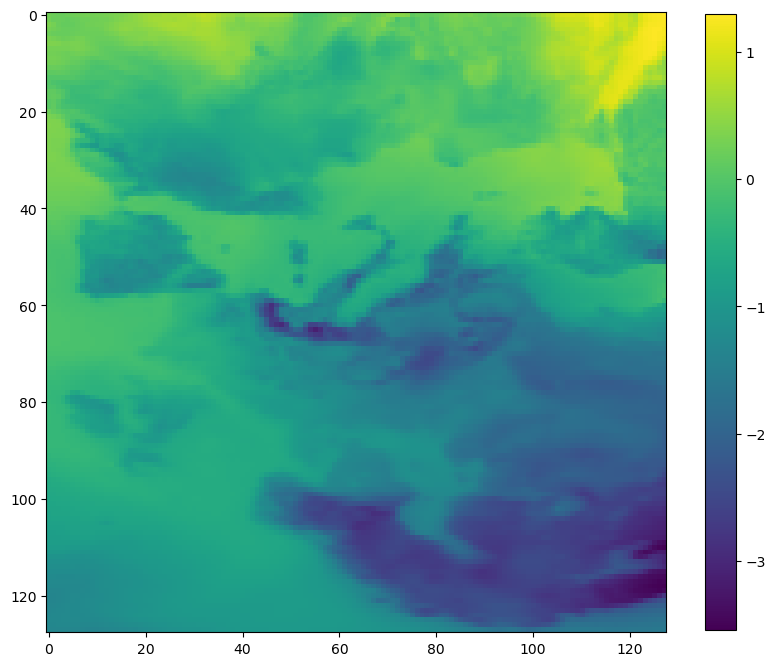

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(X.cpu().detach().numpy()[12])
plt.colorbar(shrink=0.8);

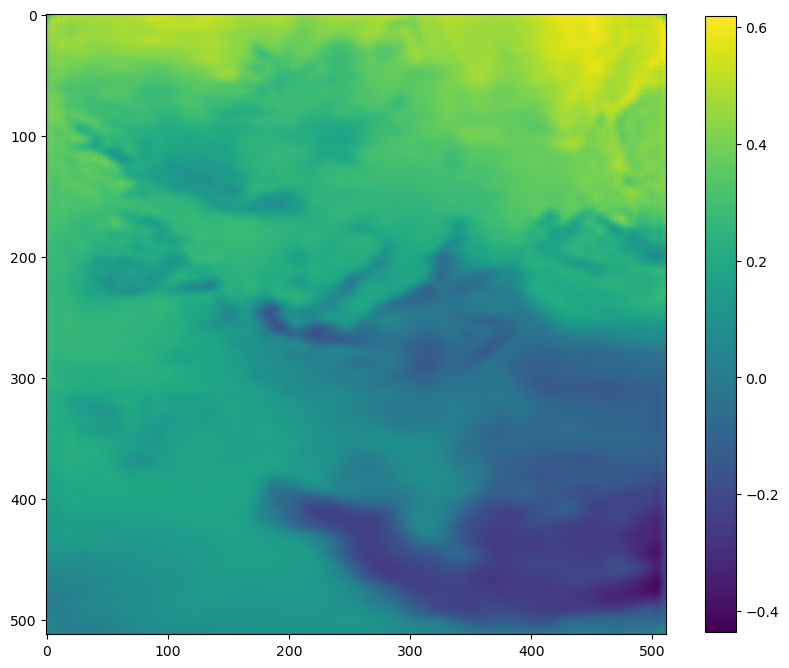

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(X_hat[0].mean(axis=0).cpu().detach().numpy())
plt.colorbar(shrink=0.8);

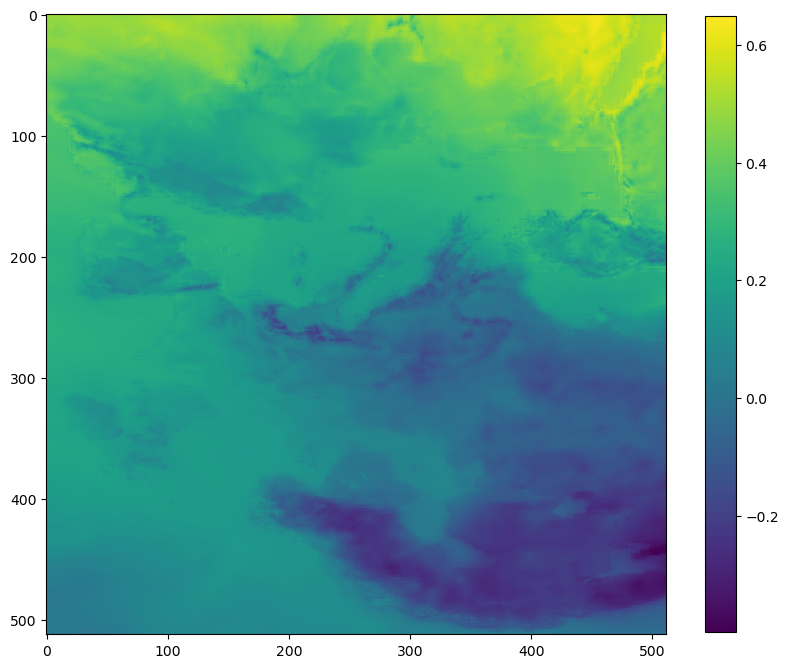

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(y.cpu().detach().numpy()[0])
plt.colorbar(shrink=0.8);